In [1]:
import simulate_matchings as sims
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from numpy.random import default_rng
rng = default_rng()
np.set_printoptions(precision=2)

In [2]:
def plot_results(data, student_qualities, scale=None):
    mean = np.mean(np.diag(data))
    norm_data = ((data - mean)/mean).T
    if scale:
        norm = colors.Normalize(-scale, +scale, clip=True)
    else:
        most = max(np.max(norm_data) - mean, mean - np.min(norm_data))
        norm = colors.Normalize(-most, +most, clip=True)
    # plt.title("student quality: {:.2f}".format(student_qualities[0] * data.shape[0]))
    plt.xticks([0, data.shape[0]-1], ["best", "worst"])
    plt.xlabel("course")
    plt.imshow(norm_data, cmap='seismic', norm=norm)
    plt.ylabel("ranked placement")
    plt.yticks([0, data.shape[0]-1], ["first", "last"])
    plt.colorbar()
    plt.show()

def plot_match_comparison(data1, data2, match_utilities, course_qualities):
    ordering = np.flip(np.argsort(match_utilities))
    width = 0.35
    fig, ax = plt.subplots()

    ax.bar(np.arange(data1.shape[0]) - 0.5 *width, data1[ordering], width, label='original')
    ax.bar(np.arange(data2.shape[0]) + 0.5 *width, data2[ordering], width, label='modified')
    ax.plot(match_utilities[ordering] / match_utilities.sum(), marker='o', c='tab:green', linestyle='dashed', label='utility')
    ax.plot(course_qualities[ordering] / course_qualities.sum(), marker='^', c='tab:red', linestyle='None', label='quality')
    ax.set_xticks([0, data1.shape[0]-1], ["best", "worst"])
    ax.set_xlabel("course")
    ax.set_ylabel("fraction")
    ax.set_ylim(0)
    
    fig.legend(bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)

    plt.show()


In [63]:
n = 16
student_weights = course_weights = np.arange(n-1, -1, -1)


In [64]:
trials = 1000
ls_res = []
ls_inputs = []
for _ in range(trials):
    student_qualities = np.ones(n)
    student_qualities /= np.sum(student_qualities)
    course_qualities = rng.random(n)
    course_qualities /= np.sum(course_qualities)
    match_utilities = sims.generate_utilities(course_qualities)
    match_utilities = match_utilities / np.sum(match_utilities)
    fixed_weights = sims.get_fixed_weights(student_qualities, course_qualities, student_weights, course_weights, 2000)
    results = sims.try_reordering(match_utilities, fixed_weights, student_weights)
    ls_res.append(results)
    ls_inputs.append([student_qualities, course_qualities, match_utilities])
ls_res = np.array(ls_res)

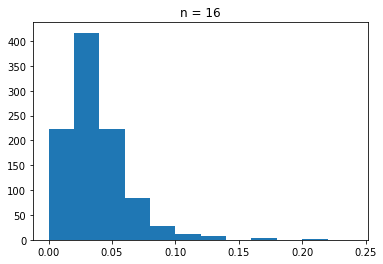

In [66]:
max_ex = (np.max(ls_res, axis=(1,2)) - np.mean(np.diagonal(ls_res, axis1=1, axis2=2), axis=1)) / np.mean(np.diagonal(ls_res, axis1=1, axis2=2), axis=1)
plt.title("n = 16")
plt.hist(max_ex, 12, (0, 0.24))
plt.show()

In [67]:
index = np.argmax(max_ex)

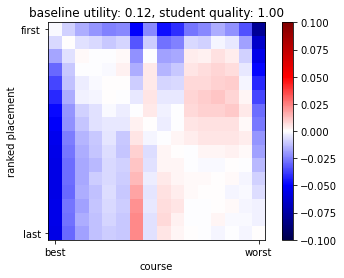

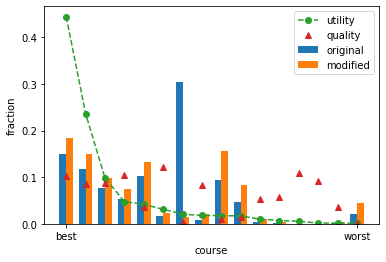

In [69]:
student_qualities, course_qualities, match_utilities = ls_inputs[index]
plot_results(ls_res[index], student_qualities, 0.1)
default_ranking = sims.default_ranking(match_utilities)
fixed_weights = sims.get_fixed_weights(student_qualities, course_qualities, student_weights, course_weights, 5000)
init_matches = sims.match_results(default_ranking, fixed_weights, student_weights)
new_matches = sims.match_results(sims.reorder_ranking(default_ranking, 6, 15), fixed_weights, student_weights)
plot_match_comparison(np.histogram(init_matches, n)[0] / init_matches.size, np.histogram(new_matches, n)[0] / new_matches.size, match_utilities, course_qualities)


In [45]:
max_ex[601]

0.332914654508674

In [53]:
print(sims.avg_utility(match_utilities, init_matches))
print(sims.avg_utility(match_utilities, new_matches))

0.17254368747751272
0.2264742929884645


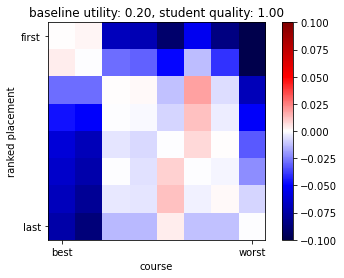

In [128]:
fixed_weights = sims.get_fixed_weights(student_qualities, course_qualities, student_weights, course_weights, 5000)
match_utilities = match_utilities / np.sum(match_utilities)
results = sims.try_reordering(match_utilities, fixed_weights, student_weights)
plot_results(results, student_qualities, 0.1)

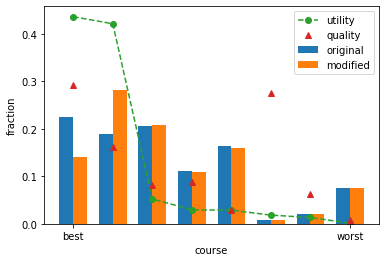

In [129]:
default_ranking = sims.default_ranking(match_utilities)
init_matches = sims.match_results(default_ranking, fixed_weights, student_weights)
new_matches = sims.match_results(sims.reorder_ranking(default_ranking, 1, 0), fixed_weights, student_weights)
plot_match_comparison(np.histogram(init_matches, n)[0] / init_matches.size, np.histogram(new_matches, n)[0] / new_matches.size, match_utilities, course_qualities)

In [130]:
print(sims.avg_utility(match_utilities, init_matches))
print(sims.avg_utility(match_utilities, new_matches))

0.19672173830641115
0.19871558229928152


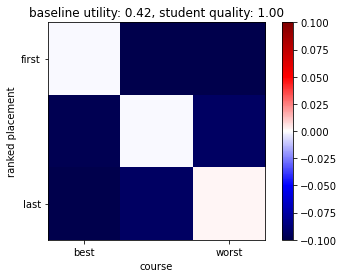

In [134]:
n = 3
student_qualities = np.ones(n)
student_qualities /= np.sum(student_qualities)
course_qualities = rng.random(n)
course_qualities /= np.sum(course_qualities)
student_weights = course_weights = np.arange(n-1, -1, -1)
match_utilities = sims.generate_utilities(course_qualities)
fixed_weights = sims.get_fixed_weights(student_qualities, course_qualities, student_weights, course_weights, 5000)
match_utilities = match_utilities / np.sum(match_utilities)
results = sims.try_reordering(match_utilities, fixed_weights, student_weights)
plot_results(results, student_qualities, 0.1)

(array([[  0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.],
        [  1.,   1.,   4.,   1.,   3.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.],
        [  1.,   4.,   2.,   8.,   6.,   2.,   0.,   2.,   0.,   0.,   0.,
           0.],
        [  3.,   9.,  12.,  11.,  13.,   4.,   7.,   2.,   1.,   0.,   0.,
           0.],
        [ 10.,  33.,  41.,  46.,  94.,  34.,  30.,   9.,   9.,   0.,   0.,
           0.],
        [  5.,  40.,  75., 129., 137.,  82.,  83.,  12.,   7.,   1.,   0.,
           0.],
        [  7.,  25.,  40., 118., 126.,  84., 153.,  53.,  17.,  11.,   0.,
           0.],
        [  5.,  29.,  46.,  93., 176., 156., 137., 118.,  80.,  30.,   5.,
           0.],
        [  0.,   7.,  56., 122., 149., 187., 257., 135., 101.,  76.,   2.,
           0.],
        [  0.,   0.,   7.,  49.,  70.,  53., 167.,  82.,  53.,  68.,  18.,
           1.],
        [  0.,   0.,   0.,  21.,  65.,  63.,  71., 114.,  73.,  29.,  22.,
           0.],

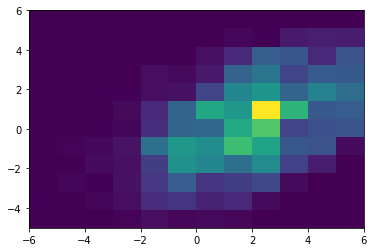

In [144]:
vals = fixed_weights - fixed_weights[:, 0][:, np.newaxis]
plt.hist2d(vals[:, 1], vals[:, 2], bins=12)

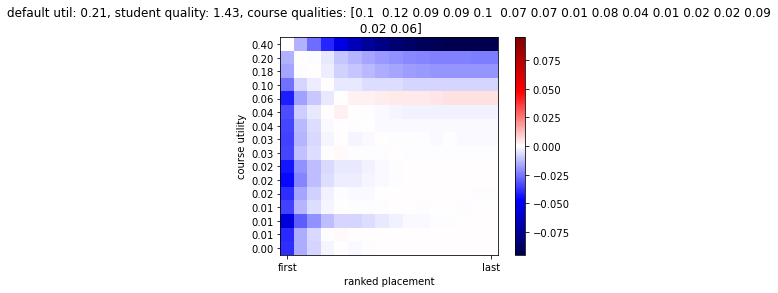

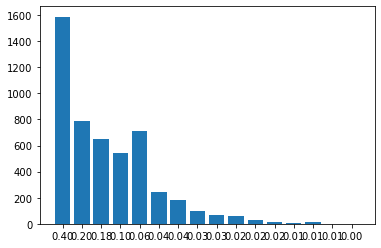

KeyboardInterrupt: 

In [ ]:
n = 16
for _ in range(3):
    student_qualities = rng.random(n)
    student_qualities /= np.sum(student_qualities)
    course_qualities = rng.random(n)
    course_qualities /= np.sum(course_qualities)
    student_weights = course_weights = np.arange(n-1, -1, -1)
    match_utilities = sims.generate_utilities(course_qualities)
    fixed_weights = sims.get_fixed_weights(student_qualities, course_qualities, student_weights, course_weights, 5000)
    matches = sims.match_results(sims.default_ranking(match_utilities), fixed_weights, student_weights)
    results1 = sims.try_reordering(match_utilities, fixed_weights, student_weights)
    plot_results(results1, student_qualities, 0.1)
    plot_matches(np.histogram(matches, bins=n)[0], match_utilities)

In [ ]:
student_qualities = rng.random(10)
student_qualities /= np.sum(student_qualities)
course_qualities = rng.random(10)
course_qualities /= np.sum(course_qualities)
student_weights = course_weights = np.arange(9, -1, -1)
match_utilities = sims.generate_utilities(course_qualities)
results2 = sims.try_reordering(match_utilities, student_qualities, course_qualities, student_weights, course_weights, 500)


In [ ]:
student_qualities = rng.random(10)
student_qualities /= np.sum(student_qualities)
course_qualities = rng.random(10)
course_qualities /= np.sum(course_qualities)
student_weights = course_weights = np.arange(9, -1, -1)
match_utilities = sims.generate_utilities(course_qualities)
results3 = sims.try_reordering(match_utilities, student_qualities, course_qualities, student_weights, course_weights, 500)

In [ ]:
student_qualities = np.arange(1, 11) / np.sum(np.arange(1, 11))
course_qualities = np.arange(1, 11) / np.sum(np.arange(1, 11))
student_weights = course_weights = np.arange(9, -1, -1)
match_utilities = np.arange(10)
results4 = sims.try_reordering(match_utilities, student_qualities, course_qualities, student_weights, course_weights, 5000)

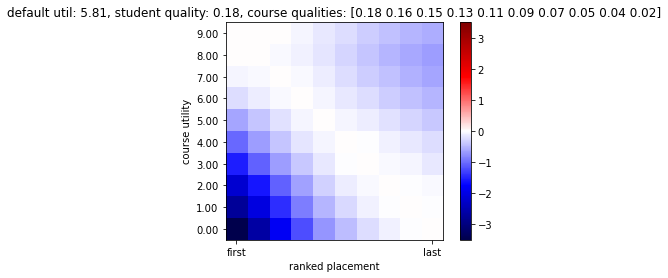

In [ ]:
plot_results(results4)

In [ ]:
student_qualities = np.arange(1, 11)
student_qualities[0] = 30
student_qualities = np.divide(student_qualities, np.sum(student_qualities))
course_qualities = np.arange(1, 11) / np.sum(np.arange(1, 11))
student_weights = course_weights = np.arange(9, -1, -1)
match_utilities = np.arange(10)
results5 = sims.try_reordering(match_utilities, student_qualities, course_qualities, student_weights, course_weights, 5000)

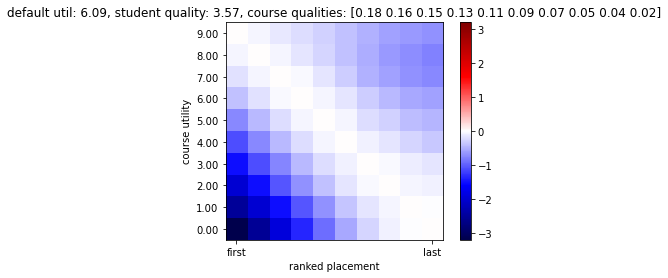

In [ ]:
plot_results(results5)

In [55]:
n = 16
course_qualities = np.arange(1, n + 1) / np.sum(np.arange(1, n + 1))
student_weights = course_weights = np.arange(n-1, -1, -1)
match_utilities = course_qualities
ranking = student_weights

qualities = []
results = []
for i in range(-12, 12, 1):
    student_qualities = np.ones(n)
    student_qualities[0] = 2 ** i
    student_qualities = np.divide(student_qualities, np.sum(student_qualities))
    qualities.append(student_qualities[0] * n)
    fixed_weights = sims.get_fixed_weights(student_qualities, course_qualities, student_weights, course_weights, 5000)
    res = sims.avg_utility(match_utilities, sims.match_results(ranking, fixed_weights, student_weights))
    results.append(res)

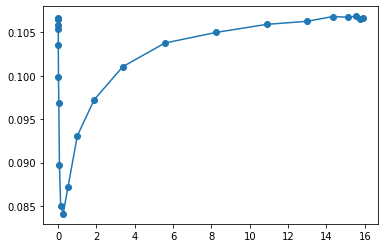

In [56]:
plt.plot(qualities, results, marker='o')

In [46]:
student_qualities = np.ones(n)
student_qualities[0] = 1000000
student_qualities /= np.sum(student_qualities)
fixed_weights_top = sims.get_fixed_weights(student_qualities, course_qualities, student_weights, course_weights, 5000)
print(student_qualities)
np.mean(fixed_weights_top, axis=0)

[1.e+00 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06
 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06]


array([375.43, 373.17, 372.  , 371.11, 370.48, 369.95, 369.53, 369.26,
       368.95, 368.74, 368.5 , 368.4 , 368.22, 368.11, 367.93, 367.89])

In [47]:
student_qualities = np.ones(n)
student_qualities[0] = 0.00001
student_qualities /= np.sum(student_qualities)
fixed_weights_bot = sims.get_fixed_weights(student_qualities, course_qualities, student_weights, course_weights, 5000)
print(student_qualities)
np.mean(fixed_weights_bot, axis=0)

[6.67e-07 6.67e-02 6.67e-02 6.67e-02 6.67e-02 6.67e-02 6.67e-02 6.67e-02
 6.67e-02 6.67e-02 6.67e-02 6.67e-02 6.67e-02 6.67e-02 6.67e-02 6.67e-02]


array([375.43, 373.34, 372.05, 371.1 , 370.52, 370.  , 369.64, 369.31,
       369.04, 368.71, 368.53, 368.38, 368.21, 368.1 , 367.95, 367.85])

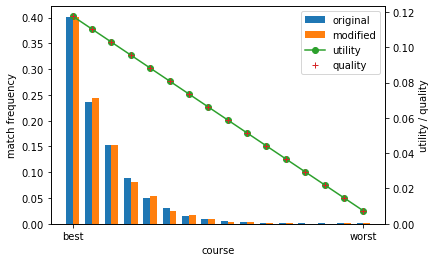

In [48]:
init_matches = sims.match_results(ranking, fixed_weights_bot, student_weights)
new_matches = sims.match_results(ranking, fixed_weights_top, student_weights)
plot_match_comparison(np.histogram(init_matches, n)[0] / init_matches.size, np.histogram(new_matches, n)[0] / new_matches.size, match_utilities / np.sum(match_utilities), course_qualities)

As quantity approaches 1, utility gets worst.

In [49]:
print(sims.avg_utility(match_utilities, init_matches))
print(sims.avg_utility(match_utilities, new_matches))

0.10680294117647059
0.10689558823529412


In [27]:
from scipy.optimize import linear_sum_assignment

In [37]:
qual1 = np.array([0.0002, 0.4999, 0.4999])
qual2 = np.array([0.999, 0.0005, 0.0005])

n, m = student_qualities.size, course_qualities.size
totals1 = np.zeros(3)
totals2 = np.zeros(3)
totals3 = np.zeros(3)
totals4 = np.zeros(3)
totals5 = np.zeros(3)
for t in range(50000):

    s_orders = [sims.generate_ordering(course_qualities) for _ in range(n)]
    c_orders1 = [sims.generate_ordering(qual1) for _ in range(n)]
    c_orders2 = [sims.generate_ordering(qual2) for _ in range(n)]
    # for _ in range(3):
        # if np.random.uniform() < 0.5:
        #     c_orders1.append(np.array([0, 1, 2]))
        #     c_orders2.append(np.array([1, 2, 0]))
        # else:
        #     c_orders1.append(np.array([0, 2, 1]))
        #     c_orders2.append(np.array([2, 1, 0]))

    weights1 = np.zeros(m)
    match_weights = np.zeros((n, m))
    for s in range(1, n):
        match_weights[s, :] += student_weights[np.argsort(s_orders[s])]
    for c in range(m):
        match_weights[:, c] += course_weights[np.argsort(c_orders1[c])]

    for c in range(m):
        fixed = match_weights.copy()
        fixed[1:, c] = -np.inf
        row, col = linear_sum_assignment(fixed, maximize=True)
        weights1[c] = int(round(fixed[row, col].sum()))

    weights2 = np.zeros(m)
    match_weights2 = np.zeros((n, m))
    for s in range(1, n):
        match_weights2[s, :] += student_weights[np.argsort(s_orders[s])]
    for c in range(m):
        match_weights2[:, c] += course_weights[np.argsort(c_orders2[c])]

    for c in range(m):
        fixed = match_weights2.copy()
        fixed[1:, c] = -np.inf
        row, col = linear_sum_assignment(fixed, maximize=True)
        weights2[c] = int(round(fixed[row, col].sum()))

    totals1 += weights1
    totals2 += weights2
    totals3 += sims.get_fixed_weights(qual1, course_qualities, student_weights, course_weights, 1)[0]
    totals4 += sims.get_fixed_weights(qual2, course_qualities, student_weights, course_weights, 1)[0]
    totals5 += sims.get_fixed_weights(qual2, course_qualities, student_weights, course_weights, 1)[0]

print(totals1 / 1000)
print(totals2 / 1000)
print(totals3 / 1000)
print(totals4 / 1000)
print(totals5 / 1000)


[316.39 291.53 279.33]
[316.52 291.47 279.35]
[316.13 291.64 279.11]
[316.25 291.57 279.12]
[316.04 291.28 279.53]


In [33]:
course_weights[np.argsort(np.array([1, 2, 0]))]

array([0, 2, 1])

In [36]:
for _ in range(200):
    print(sims.generate_ordering(qual2))

[0 2 1]
[0 2 1]
[0 1 2]
[0 2 1]
[0 1 2]
[0 2 1]
[0 2 1]
[0 1 2]
[0 2 1]
[0 1 2]
[0 2 1]
[0 2 1]
[0 2 1]
[0 2 1]
[0 2 1]
[0 2 1]
[0 2 1]
[0 1 2]
[0 2 1]
[0 2 1]
[0 2 1]
[0 1 2]
[0 2 1]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 2 1]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 2 1]
[0 1 2]
[0 2 1]
[0 2 1]
[0 1 2]
[0 2 1]
[0 2 1]
[0 1 2]
[0 2 1]
[0 1 2]
[0 1 2]
[0 2 1]
[0 2 1]
[0 2 1]
[0 1 2]
[0 1 2]
[0 2 1]
[0 2 1]
[0 1 2]
[0 2 1]
[0 1 2]
[0 2 1]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 2 1]
[0 2 1]
[0 1 2]
[0 1 2]
[0 1 2]
[0 2 1]
[0 2 1]
[0 1 2]
[0 1 2]
[0 2 1]
[0 2 1]
[0 1 2]
[0 2 1]
[0 1 2]
[0 1 2]
[0 2 1]
[0 2 1]
[0 1 2]
[0 2 1]
[0 2 1]
[0 2 1]
[0 2 1]
[0 1 2]
[2 0 1]
[0 2 1]
[0 1 2]
[0 2 1]
[0 2 1]
[0 2 1]
[0 1 2]
[0 1 2]
[0 1 2]
[0 2 1]
[0 2 1]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 2 1]
[0 1 2]
[0 1 2]
[0 2 1]
[0 2 1]
[0 1 2]
[0 2 1]
[0 1 2]
[0 1 2]
[0 2 1]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 2 1]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]


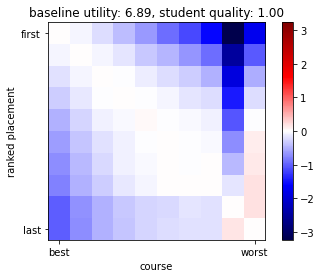

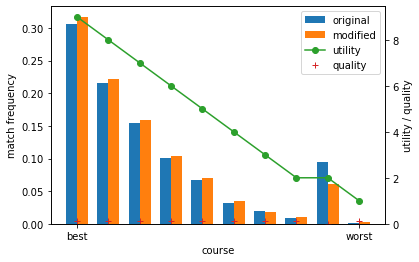

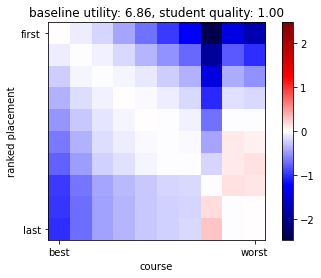

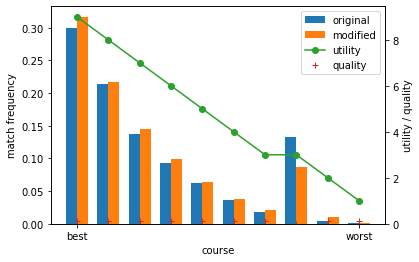

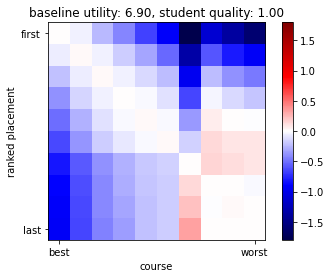

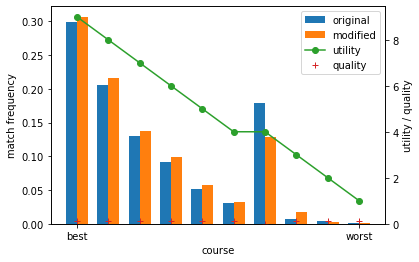

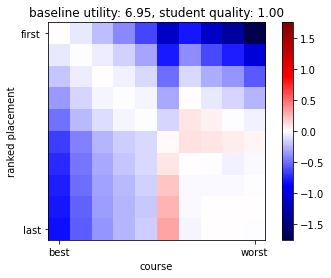

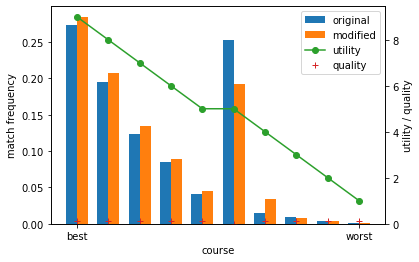

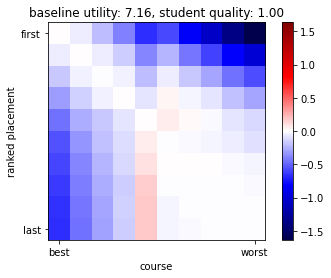

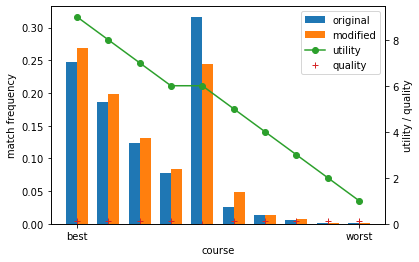

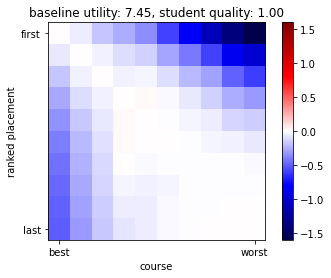

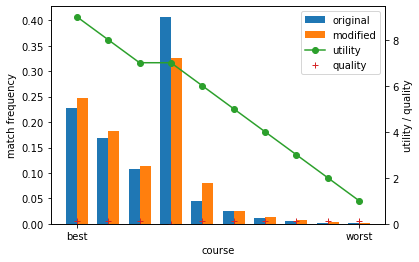

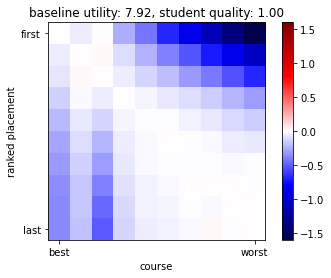

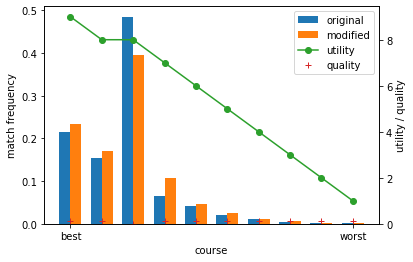

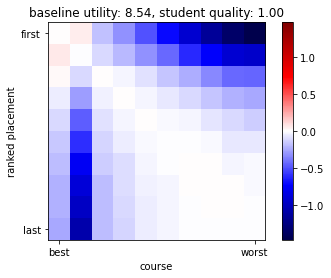

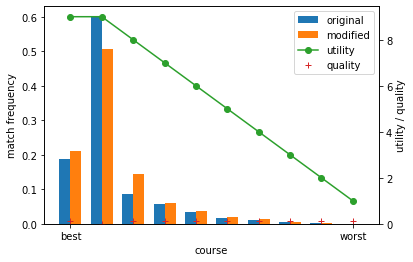

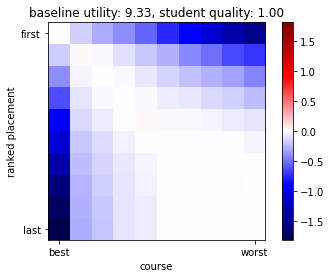

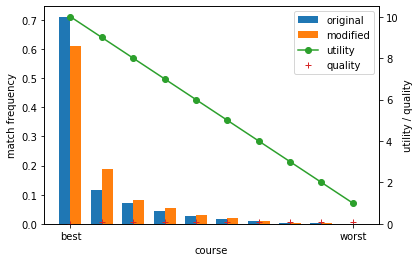

In [64]:
# checking if there is a dud course that you like to varying degrees
n = 10
student_qualities = np.ones(10) / 10
student_weights = course_weights = np.arange(9, -1, -1)
course_qualities = np.ones(10)
course_qualities[0] = 0.1
course_qualities /= np.sum(course_qualities)

for w in range(2, 11, 1):
    match_utilities = np.arange(10)
    match_utilities[0] = w
    fixed_weights = sims.get_fixed_weights(student_qualities, course_qualities, student_weights, course_weights, 5000)
    res = sims.try_reordering(match_utilities, fixed_weights, student_weights)
    plot_results(res, student_qualities)
    default_ranking = sims.default_ranking(match_utilities)
    init_matches = sims.match_results(default_ranking, fixed_weights, student_weights)
    new_matches = sims.match_results(sims.reorder_ranking(default_ranking, 10-w, 11-w), fixed_weights, student_weights)
    plot_match_comparison(np.histogram(init_matches, n)[0] / init_matches.size, np.histogram(new_matches, n)[0] / new_matches.size, match_utilities, course_qualities)
plt.show()